In [1]:
import time
import os
import sys
import logging

import numpy as np
import tenseal as ts

from sklearn.model_selection import train_test_split
os.chdir("/home/apignet/homomorphic-encryption/ckks_titanic")
from src.features import build_features
from models import encrypted_LR

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
1

1

# definition of parameters

### Paths

In [3]:
# data_path = "~/homomorphic-encryption/ckks_titanic/data/raw/"            # whole data set
DATA_PATH = "/home/apignet/homomorphic-encryption/ckks_titanic/data/quick_demo/"   # subset of the data set, with 15 train_samples and 5 test_samples
LOG_PATH = "reports/log"
LOG_FILENAME = "test_0716"

### Log 

In [4]:
fileHandler = logging.FileHandler("{0}/{1}.log".format(LOG_PATH, LOG_FILENAME))
streamHandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(format="%(asctime)s  [%(levelname)-8.8s]  %(message)s", datefmt='%m/%d/%Y %I:%M:%S %p', level = logging.DEBUG, handlers=[fileHandler, streamHandler])

### Training variables

In [5]:
EPOCH = 30
LEARNING_RATE = 0.8
REGULARIZATION_RATE = 0.5
VERBOSE = 5

## Static functions

In [6]:
def crytp_array(X, local_context):
    """
    This function encrypt a list of vector
    
    :parameters 
    ------------
    
    X ; list of list, interpreted as list of vector to encrypt
    local_context ; TenSEAL context object used to encrypt
    
    :returns
    ------------
    
    list ; list of CKKS ciphertext  
    
    """
    res = []
    for i in range(len(X)):
        res.append(ts.ckks_vector(local_context, X[i]))
        if i == len(X) // 4:
            logging.info("25 % ...")
        elif i == len(X) // 2 :
            logging.info("50 % ...")
        elif i == 3* len(X)//4:
            logging.info("75% ...")
    return res



### Confidential functions

These functions involves security breachs (as use of unencrypted data, or decryption of weights) and cannot be coded by Alice.
However, the functions encapslulate the unsafe process, so can be performed by Alice if Bob provides them. 
Therefore, they are currently passed as parameters to Alice, which only calls them.

Currently there is a huge security breach, as confidential parameters (security key for instance), which are needed by those functions, are passed in a dictionnary to Alice. 
For a safe protocole, we have to change these functions, to set up a safe communication protocole between Bob and Alice.
Alice will therefore only send the crypted data to Bob (using these functions, in which can be set up the communication process) and Bob will locally perform the functions which are currently coded bellow. 

In [7]:
def refresh(ciphertext, **kwarg):
    """
    This function is here to refresh a ciphertext. This operation reset to 0 the calculus depth of the input ciphertext 
    WARNING :  Basically the function decryt and re-encrypt the ciphertext. 
    This is not safe, this operation needs to be done by a trusted part 
    (Bob for the perfect instance, even if it requieres communications between Alice and Bob while training)
    
    :parameters 
    ------------
    
    ciphertext ; encrypted CKKS vector 
    **kwarg ; dict, must contain context and secret_key.
    
    :returns
    ------------
    
    ciphertext : encrypted CKKS vector 
    
    """
    context = kwarg.get("context", None)
    secret_key = kwarg.get("secret_key", None)
    assert context , "Context must be provided with the key : context"+str(context)
    if context.is_private():
        return ts.ckks_vector(context, ciphertext.decrypt())
    else : 
        if not secret_key:
            raise AttributeError("The secret key is not provided and the context provided is public, decryption is not possible")
        else:
            return ts.ckks_vector(context, ciphertext.decrypt(secret_key))
def loss(crypted_weight, crypted_bias, regularization,**kwarg):
    """
    This function is here to compute the cross entropy loss 
    1-NOTE : we could estimate this function homomorphically, by designing an approximation of log. 
    The prediction will stay between 0 and 1 anyway, so we should be able to do so with small degree polynomial. 
    However, we will not be able to use the metric, as the result is encrypted.
    2-NOTE : this function could be parallelized, as we do not need the result for the next epoch. 
    
    :parameters 
    ------------
    
    crypted_weight ; encrypted CKKS vector (size equal to the number of features)
    crypted_bias ; encrypted CKKS vector (size 1)
    regularization ; float, used for regulatization of the weight
    **kwarg ; dict, must contain context, secret_key, unencrytped_X and unencrypted_Y 
    
    :returns
    ------------
    
    loss : float (rounded to 3 digits)
    
    
    """
    context = kwarg.get("context", None)
    secret_key = kwarg.get("secret_key", None)
    unencrypted_X = kwarg.get("unencrypted_X", None)
    unencrypted_Y = kwarg.get("unencrypted_Y", None)
    if not context:
        raise AttributeError("Context must be provided in the **kwarg, with the key : context")
    if unencrypted_X is None:
        raise AttributeError("Unencrypted samples must be provided in the **kwarg, with the key : unencrypted_X")
    if unencrypted_Y is None:
        raise AttributeError("Unencrypted labels must be provided in the **kwarg, with the key : unencrypted_Y")
    
    if context.is_private():
            weight = np.array(crypted_weight.decrypt())
            bias = np.array(crypted_bias.decrypt())
    else : 
        if not secret_key:
            raise AttributeError("The secret key is not provided and the context provided is public, decryption is not possible. Pass a private context or the secret key")
        else:
            weight = np.array(crypted_weight.decrypt(secret_key))
            bias = np.array(crypted_bias.decrypt(secret_key))
            
    re = unencrypted_X.dot(weight) + bias  # we use cross entropy loss function
    prediction = (np.float_power(re, 3)) * -0.004 + re * 0.197 + 0.5
    loss = -np.log(prediction).dot(unencrypted_Y)
    loss -= (1 - np.array(unencrypted_Y)).T.dot(np.log(1 - prediction))
    loss += (regularization / 2) * (np.array(weight).dot(weight) + np.float_power(bias, 2))

    return np.round(loss[0], 3)
            
def accuracy(crypted_weight, crypted_bias, prior_unencrypted_X = None, prior_unencrypted_Y=None, **kwarg):
    """
    This function is here to compute the accuracy
    1-NOTE : we could maybe estimate this function homomorphically, by designing an approximation of the sign function. 
    However, this kind of approximation seems really hard to set up 
    Therefore, we will not be able to use the metric, as the result is encrypted.
    2-NOTE : this function could be parallelized, as we do not need the result for the next epoch. 
    
    :parameters 
    ------------
    
    crypted_weight ; encrypted CKKS vector (size equal to the number of features)
    crypted_bias ; encrypted CKKS vector (size 1)
    (Optionnal) prior_unencrypted_X ; samples on which the model accuracy will be computed. 
                                If not provided, the accuracy will be computed with the data provided in the kwarg
    (Optionnal) prior_unencrypted_Y ; labels on which the model accuracy will be computed. If not provided.
                                If not provided, the accuracy will be computed with the data provided in the kwarg
    **kwarg ; dict, must contain context, secret_key, (Optionnal) unencrytped_X and (Optionnal) unencrypted_Y 
    
    :returns
    ------------
    
    accuray : float (rounded to 2 digits)
    
    
    """
    context = kwarg.get("context", None)
    if not context:
        raise AttributeError("Context must be provided in the **kwarg, with the key : context")
    secret_key = kwarg.get("secret_key", None)
    if prior_unencrypted_X is None:
        unencrypted_X = kwarg.get("unencrypted_X", None)
        if unencrypted_X is None:
            raise AttributeError("Unencrypted samples must be provided, either in the arguments, or in the **kwarg, with the key : unencrypted_X")
    else:
        unencrypted_X = np.array(prior_unencrypted_X)
    if prior_unencrypted_Y is None:
        unencrypted_Y = kwarg.get("unencrypted_Y", None)
        if unencrypted_Y is None:
            raise AttributeError("Unencrypted labels must be provided, either in the arguments, or in the **kwarg, with the key : unencrypted_Y")
    else:
        unencrypted_Y = np.array(prior_unencrypted_Y)
    if context.is_private():
            weight = np.array(crypted_weight.decrypt())
            bias = np.array(crypted_bias.decrypt())
    else : 
        if not secret_key:
            raise AttributeError("The secret key is not provided and the context provided is public, decryption is not possible. Pass a private context or the secret key")
        else:
            weight = np.array(crypted_weight.decrypt(secret_key))
            bias = np.array(crypted_bias.decrypt(secret_key))
            
    re = unencrypted_X.dot(weight) + bias  
    prediction = (np.float_power(re, 3)) * -0.004 + re * 0.197 + 0.5
    print(prediction)
    return (np.abs((unencrypted_Y-prediction.reshape(unencrypted_Y.shape))) < 0.5).astype(float).mean()
    

# Loading and processing the data

In [8]:
logging.info(os.getcwd())
raw_train, raw_test = build_features.data_import(DATA_PATH)
train, submission_test = build_features.processing(raw_train, raw_test)

07/17/2020 09:05:57 AM  [INFO    ]  /home/apignet/homomorphic-encryption/ckks_titanic
07/17/2020 09:05:57 AM  [INFO    ]  loading the data into memory (pandas df)
07/17/2020 09:05:57 AM  [INFO    ]  Done
07/17/2020 09:05:57 AM  [INFO    ]  making final data set from raw data
07/17/2020 09:05:57 AM  [INFO    ]  Done


In [9]:
train, test = train_test_split(train, test_size=0.15)
train_labels = train.Survived
test_labels = test.Survived
train_features = train.drop("Survived", axis=1)
test_features = test.drop("Survived", axis=1)

# Definition of safety parameters

In [10]:
logging.info('Definition of safety parameters...')
timer = time.time()
# context = ts.context(ts.SCHEME_TYPE.CKKS, 32768,
# coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 60])
#context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[40, 21, 21, 21, 21, 21, 21, 40])

context = ts.context(ts.SCHEME_TYPE.CKKS, 16384, coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 40, 40, 60])
context.global_scale = pow(2, 40)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
logging.info('Generation of the Galois Key...')
timer = time.time()
context.generate_galois_keys()
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")

#logging.info('Generation of the secret key...')
#timer = time.time()
secret_key = context.secret_key()
#context.make_context_public()
#logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
#if context.is_public():
#    logging.info("The context is now public, the context do not hold the secret key anymore, and decrypt methods need the secret key to be provide,")




07/17/2020 09:05:58 AM  [INFO    ]  Definition of safety parameters...
07/17/2020 09:05:58 AM  [INFO    ]  Done. 0.46 seconds
07/17/2020 09:05:58 AM  [INFO    ]  Generation of the Galois Key...
07/17/2020 09:06:03 AM  [INFO    ]  Done. 4.71 seconds


# Data encryption

In [11]:
logging.info("Data encryption...")
timer = time.time()
encrypted_X = crytp_array(train_features.to_numpy(), context)
encrypted_Y = crytp_array(train_labels.to_numpy().reshape((-1, 1)), context)
encrypted_test_X = crytp_array(test_features.to_numpy(), context)
encrypted_test_Y = crytp_array(test_labels.to_numpy().reshape((-1, 1)), context)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")

07/17/2020 09:06:03 AM  [INFO    ]  Data encryption...
07/17/2020 09:06:03 AM  [INFO    ]  25 % ...
07/17/2020 09:06:03 AM  [INFO    ]  50 % ...
07/17/2020 09:06:04 AM  [INFO    ]  75% ...
07/17/2020 09:06:04 AM  [INFO    ]  25 % ...
07/17/2020 09:06:04 AM  [INFO    ]  50 % ...
07/17/2020 09:06:04 AM  [INFO    ]  75% ...
07/17/2020 09:06:04 AM  [INFO    ]  25 % ...
07/17/2020 09:06:04 AM  [INFO    ]  50 % ...
07/17/2020 09:06:04 AM  [INFO    ]  75% ...
07/17/2020 09:06:04 AM  [INFO    ]  25 % ...
07/17/2020 09:06:04 AM  [INFO    ]  50 % ...
07/17/2020 09:06:04 AM  [INFO    ]  75% ...
07/17/2020 09:06:04 AM  [INFO    ]  Done. 1.2 seconds


# Initialize the weight

The weights have to be crypted 

In [12]:
weight_ne = [0. for _ in range(encrypted_test_X[0].size())]
weight = ts.ckks_vector(context, weight_ne)
weight_ne = np.array(weight_ne)
bias_ne = [0.]
bias = ts.ckks_vector(context, bias_ne)
bias_ne = np.array(bias_ne)

The confidential data as yet stored into a dictionnary, and will be used during the training only by functions which are passed as arguments to the fit methods. This encapsulation of sensitive data will allows us to ensure security during training later. 

In [13]:
confidential_data = {'context':context,
                     'secret_key':secret_key, 
                     'unencrypted_X':train_features.to_numpy(),
                     'unencrypted_Y':train_labels.to_numpy().reshape((-1, 1)) 
                    }

# Training

In [14]:
logging.info("Model initialization")
model = encrypted_LR.LogisticRegressionHE(init_weight=weight,
                                          init_bias=bias,
                                          weight_ne=weight_ne,
                                          bias_ne=bias_ne,
                                          refresh_function=refresh, 
                                          confidential_kwarg=confidential_data,
                                          loss=loss,
                                          accuracy=accuracy,
                                          safety=False, 
                                          verbose=VERBOSE,
                                          num_iter=EPOCH,
                                          lr=LEARNING_RATE,
                                          reg_para=REGULARIZATION_RATE)
logging.info("Training starting")
model.fit(encrypted_X, encrypted_Y, X_ne=train_features.to_numpy(), Y_ne=train_labels.to_numpy().reshape((-1, 1)))
logging.info("Training done. " + str(round(time.time() - timer, 2)) + " seconds")

07/17/2020 09:06:04 AM  [INFO    ]  Model initialization
07/17/2020 09:06:04 AM  [INFO    ]  Training starting
07/17/2020 09:06:17 AM  [INFO    ]  iteration number 1 is starting
07/17/2020 09:06:17 AM  [INFO    ]  Loss : 6.942.
07/17/2020 09:06:17 AM  [DEBUG   ]  error 0
07/17/2020 09:07:20 AM  [INFO    ]  iteration number 6 is starting
07/17/2020 09:07:20 AM  [INFO    ]  Loss : 4.65.
07/17/2020 09:07:20 AM  [DEBUG   ]  error 0
07/17/2020 09:08:22 AM  [INFO    ]  iteration number 11 is starting
07/17/2020 09:08:22 AM  [INFO    ]  Loss : 4.106.
07/17/2020 09:08:22 AM  [DEBUG   ]  error 0
07/17/2020 09:09:25 AM  [INFO    ]  iteration number 16 is starting
07/17/2020 09:09:25 AM  [INFO    ]  Loss : 3.928.
07/17/2020 09:09:25 AM  [DEBUG   ]  error 0
07/17/2020 09:10:27 AM  [INFO    ]  iteration number 21 is starting
07/17/2020 09:10:27 AM  [INFO    ]  Loss : 3.859.
07/17/2020 09:10:27 AM  [DEBUG   ]  error 0
07/17/2020 09:11:30 AM  [INFO    ]  iteration number 26 is starting
07/17/2020 09:

# Accuracy

In [18]:
acc = model.accuracy(unencrypted_X=test_features.to_numpy(), unencrypted_Y=test_labels.to_numpy().reshape((-1, 1)))
print(test_labels.to_numpy())
logging.info("Accuracy : %s " % acc)

[0.54959876 0.37809316 0.07631211]
[1. 0. 0.]
07/17/2020 09:13:08 AM  [INFO    ]  Accuracy : 1.0 


# Figures

## Loss 

Text(0.5, 1.0, 'Loss evolution')

07/17/2020 09:14:41 AM  [DEBUG   ]  update_title_pos
07/17/2020 09:14:41 AM  [DEBUG   ]  update_title_pos
07/17/2020 09:14:41 AM  [DEBUG   ]  update_title_pos
07/17/2020 09:14:41 AM  [DEBUG   ]  update_title_pos
07/17/2020 09:14:41 AM  [DEBUG   ]  update_title_pos


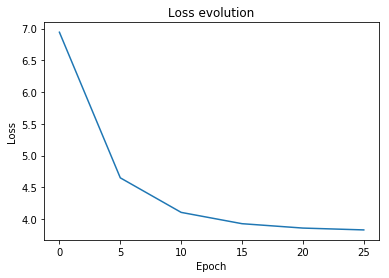

In [20]:
plt.plot([i*VERBOSE for i in range(len(model.loss_list))], model.loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution')

## Error of encryption

Text(0.5, 1.0, 'Relative error between encrypted gradient and unencrypted gradient')

07/17/2020 09:13:33 AM  [DEBUG   ]  update_title_pos
07/17/2020 09:13:33 AM  [DEBUG   ]  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/apignet/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
07/17/2020 09:13:33 AM  [DEBUG   ]  update_title_pos
07/17/2020 09:13:33 AM  [DEBUG   ]  update_title_pos
07/17/2020 09:13:34 AM  [DEBUG   ]  update_title_pos
07/17/2020 09:13:34 AM  [DEBUG   ]  update_title_pos


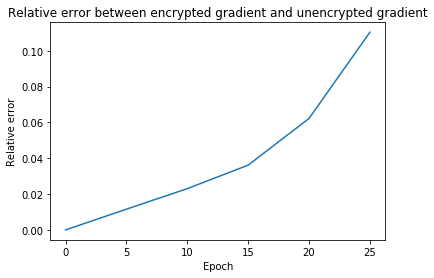

In [19]:
plt.plot([i*VERBOSE for i in range(len(model.error))], model.error)
plt.xlabel('Epoch')
plt.ylabel('Relative error')
plt.title('Relative error between encrypted gradient and unencrypted gradient')